## Wczytanie bibliotek

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import xgboost as xgb
import time
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from tqdm import tqdm
import optuna
from mpl_toolkits.mplot3d import Axes3D

## Wczytanie danych
Dane będą wczytywane z różnych plików, zostaną wczytane dane treningowe oraz testowe. Plik test data zawiera wszelkie cechy oprócz nazwy pokemona.

In [2]:
train_data = pd.read_csv("data/train_data.csv")
test_part1 = pd.read_csv("data/test_data.csv")
test_part2 = pd.read_csv("data/test_pokemon.csv")
test_data = pd.concat([test_part1, test_part2], axis=1)

In [3]:
train_data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,59,Arcanine,Fire,NaN,555,82,110,88,105,72,98,1,False
1,107,Hitmonchan,Fighting,NaN,455,47,97,84,27,121,79,1,False
2,123,Scyther,Bug,Flying,500,63,113,86,56,73,109,1,False
3,35,Clefairy,Fairy,NaN,323,67,54,46,58,62,36,1,False
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,97,193,102,157,98,133,1,True


In [4]:
test_data['Total'] = test_data['HP'] + test_data['Attack'] + test_data['Defense'] + test_data['Sp. Atk'] + test_data['Sp. Def'] + test_data['Speed']
test_data.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Name,Total
0,Grass,Poison,79,103,119,123,116,85,1,False,VenusaurMega Venusaur,625
1,Fairy,NaN,69,35,53,63,64,39,1,False,Clefairy,323
2,Water,NaN,39,41,45,43,42,90,1,False,Poliwag,300
3,Normal,NaN,52,51,46,45,42,52,1,False,Ditto,288
4,Water,Fighting,89,93,98,80,87,63,1,False,Poliwrath,510


## Przetworzenie danych

### Usunięcie brakujących wartości

In [5]:
print("Brakujące wartości dla danych treningowych:")
print(train_data.isna().sum())

Brakujące wartości dla danych treningowych:
#                0
Name             0
Type 1           0
Type 2        1760
Total            0
HP               0
Attack           0
Defense          0
Sp. Atk          0
Sp. Def          0
Speed            0
Generation       0
Legendary        0
dtype: int64


In [6]:
print("Brakujące wartości dla danych testowych:")
print(test_data.isna().sum())

Brakujące wartości dla danych testowych:
Type 1           0
Type 2        1350
HP               0
Attack           0
Defense          0
Sp. Atk          0
Sp. Def          0
Speed            0
Generation       0
Legendary        0
Name             0
Total            0
dtype: int64


In [7]:
train_notna_data = train_data.fillna("Other")
test_notna_data = test_data.fillna("Other")

In [8]:
print("Brakujące wartości dla danych treningowych:")
print(train_notna_data.isna().sum())

Brakujące wartości dla danych treningowych:
#             0
Name          0
Type 1        0
Type 2        0
Total         0
HP            0
Attack        0
Defense       0
Sp. Atk       0
Sp. Def       0
Speed         0
Generation    0
Legendary     0
dtype: int64


In [9]:
print("Brakujące wartości dla danych testowych:")
print(test_notna_data.isna().sum())

Brakujące wartości dla danych testowych:
Type 1        0
Type 2        0
HP            0
Attack        0
Defense       0
Sp. Atk       0
Sp. Def       0
Speed         0
Generation    0
Legendary     0
Name          0
Total         0
dtype: int64


### Usunięcie niepoprawny wartości

In [10]:
train_clean = train_notna_data[(train_notna_data.HP > 0) & (train_notna_data.Attack > 0) & (train_notna_data.Defense > 0)].reset_index(drop=True)

columns = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for column in columns:
    print(f"Wiersze w {column} które mają wartość poniżej lub równe 0: {len(train_clean[train_clean[column] <= 0])}")

Wiersze w Total które mają wartość poniżej lub równe 0: 0
Wiersze w HP które mają wartość poniżej lub równe 0: 0
Wiersze w Attack które mają wartość poniżej lub równe 0: 0
Wiersze w Defense które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Atk które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Def które mają wartość poniżej lub równe 0: 0
Wiersze w Speed które mają wartość poniżej lub równe 0: 0


In [11]:
test_clean = test_notna_data[(test_notna_data.HP > 0) & (test_notna_data.Attack > 0) & (test_notna_data.Defense > 0)].reset_index(drop=True)

columns = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for column in columns:
    print(f"Wiersze w {column} które mają wartość poniżej lub równe 0: {len(test_clean[test_clean[column] <= 0])}")

Wiersze w Total które mają wartość poniżej lub równe 0: 0
Wiersze w HP które mają wartość poniżej lub równe 0: 0
Wiersze w Attack które mają wartość poniżej lub równe 0: 0
Wiersze w Defense które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Atk które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Def które mają wartość poniżej lub równe 0: 0
Wiersze w Speed które mają wartość poniżej lub równe 0: 0


### Normalizacja danych

In [12]:
def transform_dataset(data):
    data.Legendary = data.Legendary.astype(int)
    label_enc = LabelEncoder()
    minmax_scaler = MinMaxScaler()
    df_cat = pd.DataFrame()
    for column in ['Name', 'Type 1', 'Type 2']:
        df_cat[column] = label_enc.fit_transform(data[column])
    df_num = data[['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
    columns = df_num.columns
    np_num = minmax_scaler.fit_transform(df_num)
    df_num_norm = pd.DataFrame(np_num, columns=columns)
    df_prepared = pd.concat([df_num_norm, df_cat, data['Generation']], axis=1)
    return df_prepared

train_df = transform_dataset(train_clean)
test_df = transform_dataset(test_clean)

In [13]:
train_df.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Name,Type 1,Type 2,Generation
0,0.615385,0.318898,0.550505,0.459893,0.507614,0.488189,0.603896,6,5,8,1
1,0.444444,0.181102,0.484848,0.438503,0.111675,0.874016,0.480519,60,4,8,1
2,0.521368,0.244094,0.565657,0.449198,0.258883,0.496063,0.675325,133,0,4,1
3,0.218803,0.259843,0.267677,0.235294,0.269036,0.409449,0.201299,23,3,8,1
4,1.000000,0.377953,0.969697,0.534759,0.771574,0.692913,0.831169,92,12,3,1


In [14]:
test_df.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Name,Type 1,Type 2,Generation
0,0.735043,0.307087,0.515152,0.623656,0.597990,0.820312,0.522293,154,7,9,1
1,0.218803,0.267717,0.171717,0.268817,0.296482,0.414062,0.229299,23,3,8,1
2,0.179487,0.149606,0.202020,0.225806,0.195980,0.242188,0.554140,118,14,8,1
3,0.158974,0.200787,0.252525,0.231183,0.206030,0.242188,0.312102,28,10,8,1
4,0.538462,0.346457,0.464646,0.510753,0.381910,0.593750,0.382166,120,14,3,1


## Regresja dla zmiennej Total

### Podział danych

In [102]:
scores_total = {}
X_train, y_train = train_df.drop('Total', axis=1), train_clean.Total
X_test, y_test = test_df.drop('Total', axis=1), test_clean.Total

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3308, 10) (3308,)
(2541, 10) (2541,)


In [56]:
X_train_tsne_dict = {}
X_test_tsne_dict = {}
for k in [2, 4, 6, 8]:
    start = time.time()
    tsne = TSNE(n_components=k, method='exact', n_jobs=-1)
    X_train_tsne = tsne.fit_transform(X_train)
    X_test_tsne = tsne.fit_transform(X_test)
    X_train_tsne_dict[k] = X_train_tsne
    X_test_tsne_dict[k] = X_test_tsne
    stop = time.time()
    print(f"Liczba cech: {k} - czas: {stop - start} sec")

Liczba cech: 2 - czas: 275.8313043117523 sec
Liczba cech: 4 - czas: 422.56461119651794 sec
Liczba cech: 6 - czas: 451.9609341621399 sec
Liczba cech: 8 - czas: 460.13820934295654 sec


### Regresja liniowa

In [122]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [123]:
y_pred = lin_reg.predict(X_test)
scores_total["lin_reg"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_total['lin_reg'][0]}")
print(f"R-squared: {scores_total['lin_reg'][1]}")

MSE: 2.0923
R-squared: 0.9998


#### PCA

In [124]:
scores_total_pca = {}
for k in [2, 4, 6, 8]:
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_pca, y_train)
    y_pred = lin_reg.predict(X_test_pca)
    scores_total_pca[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_total_pca[k][0]}", end=' ')
    print(f"R-squared: {scores_total_pca[k][1]}, liczba cech po redukcji {k}")

MSE: 152.4775 R-squared: 0.9883, liczba cech po redukcji 2
MSE: 152.4775 R-squared: 0.9883, liczba cech po redukcji 4
MSE: 152.4775 R-squared: 0.9883, liczba cech po redukcji 6
MSE: 152.4775 R-squared: 0.9883, liczba cech po redukcji 8


In [125]:
df_lin_reg_pca = pd.DataFrame(scores_total_pca)
df_lin_reg_pca.index = ['MSE', 'R-squared']
df_lin_reg_pca

,2,4,6,8
MSE,152.4775,152.4775,152.4775,152.4775
R-squared,0.9883,0.9883,0.9883,0.9883


#### t-SNE

In [126]:
scores_total_tsne = {}
for k, (X_train_tsne, X_test_tsne) in zip(X_train_tsne_dict.keys(), zip(X_train_tsne_dict.values(), X_test_tsne_dict.values())):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_tsne, y_train)
    y_pred = lin_reg.predict(X_test_tsne)
    scores_total_tsne[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), 
                            np.round(r2_score(y_true=y_test, y_pred=y_pred), 4))
    print(f"MSE: {scores_total_tsne[k][0]}", end=' ')
    print(f"R-squared: {scores_total_tsne[k][1]}, liczba cech po redukcji {k}")

MSE: 13028.904 R-squared: 0.0027, liczba cech po redukcji 2
MSE: 11256.9394 R-squared: 0.1383, liczba cech po redukcji 4
MSE: 11672.9256 R-squared: 0.1065, liczba cech po redukcji 6
MSE: 11986.6531 R-squared: 0.0824, liczba cech po redukcji 8


In [127]:
df_lin_reg_tsne = pd.DataFrame(scores_total_tsne)
df_lin_reg_tsne.index = ['MSE', 'R-squared']
df_lin_reg_tsne

,2,4,6,8
MSE,13028.9040,11256.9394,11672.9256,11986.6531
R-squared,0.0027,0.1383,0.1065,0.0824


### Regresja grzebietowa

In [128]:
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

Ridge()

In [129]:
y_pred = ridge_reg.predict(X_test)
scores_total["ridge"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_total['ridge'][0]}")
print(f"R-squared: {scores_total['ridge'][1]}")

MSE: 3.473
R-squared: 0.9997


#### PCA

In [130]:
scores_total_pca = {}
for k in [2, 4, 6, 8]:
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    ridge_reg = Ridge()
    ridge_reg.fit(X_train_pca, y_train)
    y_pred = ridge_reg.predict(X_test_pca)
    scores_total_pca[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_total_pca[k][0]}", end=' ')
    print(f"R-squared: {scores_total_pca[k][1]}, liczba cech po redukcji {k}")

MSE: 12952.9216 R-squared: 0.0085, liczba cech po redukcji 2
MSE: 1001.9875 R-squared: 0.9233, liczba cech po redukcji 4
MSE: 365.6994 R-squared: 0.972, liczba cech po redukcji 6
MSE: 153.7005 R-squared: 0.9882, liczba cech po redukcji 8


In [131]:
df_ridge_reg_pca = pd.DataFrame(scores_total_pca)
df_ridge_reg_pca.index = ['MSE', 'R-squared']
df_ridge_reg_pca

,2,4,6,8
MSE,12952.9216,1001.9875,365.6994,153.7005
R-squared,0.0085,0.9233,0.9720,0.9882


#### TSNE

In [132]:
scores_total_tsne = {}
for k, (X_train_tsne, X_test_tsne) in zip(X_train_tsne_dict.keys(), zip(X_train_tsne_dict.values(), X_test_tsne_dict.values())):
    ridge_reg = Ridge()
    ridge_reg.fit(X_train_tsne, y_train)
    y_pred = ridge_reg.predict(X_test_tsne)
    scores_total_tsne[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_total_tsne[k][0]}", end=' ')
    print(f"R-squared: {scores_total_tsne[k][1]}, liczba cech po redukcji {k}")

MSE: 13028.904 R-squared: 0.0027, liczba cech po redukcji 2
MSE: 11256.9408 R-squared: 0.1383, liczba cech po redukcji 4
MSE: 11672.8917 R-squared: 0.1065, liczba cech po redukcji 6
MSE: 11986.5139 R-squared: 0.0824, liczba cech po redukcji 8


In [133]:
df_ridge_reg_tsne = pd.DataFrame(scores_total_tsne)
df_ridge_reg_tsne.index = ['MSE', 'R-squared']
df_ridge_reg_tsne

,2,4,6,8
MSE,13028.9040,11256.9408,11672.8917,11986.5139
R-squared,0.0027,0.1383,0.1065,0.0824


### Lasso

In [134]:
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

Lasso()

In [135]:
y_pred = lasso_reg.predict(X_test)
scores_total["lasso"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_total['lasso'][0]}")
print(f"R-squared: {scores_total['lasso'][1]}")

MSE: 174.0233
R-squared: 0.9867


#### PCA

In [136]:
scores_total_pca = {}
for k in [2, 4, 6, 8]:
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    lasso_reg = Lasso()
    lasso_reg.fit(X_train_pca, y_train)
    y_pred = lasso_reg.predict(X_test_pca)
    scores_total_pca[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_total_pca[k][0]}", end=' ')
    print(f"R-squared: {scores_total_pca[k][1]}, liczba cech po redukcji {k}")

MSE: 12952.4669 R-squared: 0.0085, liczba cech po redukcji 2
MSE: 1026.6236 R-squared: 0.9214, liczba cech po redukcji 4
MSE: 458.6463 R-squared: 0.9649, liczba cech po redukcji 6
MSE: 403.3173 R-squared: 0.9691, liczba cech po redukcji 8


In [137]:
df_lasso_reg_pca = pd.DataFrame(scores_total_pca)
df_lasso_reg_pca.index = ['MSE', 'R-squared']
df_lasso_reg_pca

,2,4,6,8
MSE,12952.4669,1026.6236,458.6463,403.3173
R-squared,0.0085,0.9214,0.9649,0.9691


#### t-SNE

In [138]:
scores_total_tsne = {}
for k, (X_train_tsne, X_test_tsne) in zip(X_train_tsne_dict.keys(), zip(X_train_tsne_dict.values(), X_test_tsne_dict.values())):
    lasso_reg = Lasso()
    lasso_reg.fit(X_train_tsne, y_train)
    y_pred = lasso_reg.predict(X_test_tsne)
    scores_total_tsne[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_total_tsne[k][0]}", end=' ')
    print(f"R-squared: {scores_total_tsne[k][1]}, liczba cech po redukcji {k}")

MSE: 13029.0321 R-squared: 0.0026, liczba cech po redukcji 2
MSE: 11257.0628 R-squared: 0.1383, liczba cech po redukcji 4
MSE: 11648.0144 R-squared: 0.1084, liczba cech po redukcji 6
MSE: 11927.401 R-squared: 0.087, liczba cech po redukcji 8


In [139]:
df_lasso_reg_tsne = pd.DataFrame(scores_total_tsne)
df_lasso_reg_tsne.index = ['MSE', 'R-squared']
df_lasso_reg_tsne

,2,4,6,8
MSE,13029.0321,11257.0628,11648.0144,11927.401
R-squared,0.0026,0.1383,0.1084,0.087


### Regresja xgboost

In [140]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [141]:
y_pred = xgb_reg.predict(X_test)
scores_total["xgb"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_total["xgb"][0]}")
print(f"R-squared: {scores_total["xgb"][1]}")

MSE: 127.6226
R-squared: 0.9902


#### PCA

In [142]:
scores_total_pca = {}
for k in [2, 4, 6, 8]:
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    xgb_reg = xgb.XGBRegressor()
    xgb_reg.fit(X_train_pca, y_train)
    y_pred = xgb_reg.predict(X_test_pca)
    scores_total_pca[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_total_pca[k][0]}", end=' ')
    print(f"R-squared: {scores_total_pca[k][1]}, liczba cech po redukcji {k}")

MSE: 206.4147 R-squared: 0.9842, liczba cech po redukcji 2
MSE: 30.2405 R-squared: 0.9977, liczba cech po redukcji 4
MSE: 39.4272 R-squared: 0.997, liczba cech po redukcji 6
MSE: 56.3285 R-squared: 0.9957, liczba cech po redukcji 8


In [143]:
df_xgb_reg_pca = pd.DataFrame(scores_total_pca)
df_xgb_reg_pca.index = ['MSE', 'R-squared']
df_xgb_reg_pca

,2,4,6,8
MSE,206.4147,30.2405,39.4272,56.3285
R-squared,0.9842,0.9977,0.9970,0.9957


#### t-SNE

In [144]:
scores_total_tsne = {}
for k, (X_train_tsne, X_test_tsne) in zip(X_train_tsne_dict.keys(), zip(X_train_tsne_dict.values(), X_test_tsne_dict.values())):
    xgb_reg = xgb.XGBRegressor()
    xgb_reg.fit(X_train_tsne, y_train)
    y_pred = xgb_reg.predict(X_test_tsne)
    scores_total_tsne[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_total_tsne[k][0]}", end=' ')
    print(f"R-squared: {scores_total_tsne[k][1]}, liczba cech po redukcji {k}")

MSE: 19607.4963 R-squared: -0.5009, liczba cech po redukcji 2
MSE: 12812.8694 R-squared: 0.0192, liczba cech po redukcji 4
MSE: 14148.4082 R-squared: -0.083, liczba cech po redukcji 6
MSE: 12592.9818 R-squared: 0.036, liczba cech po redukcji 8


In [145]:
df_xgb_reg_tsne = pd.DataFrame(scores_total_tsne)
df_xgb_reg_tsne.index = ['MSE', 'R-squared']
df_xgb_reg_tsne

,2,4,6,8
MSE,19607.4963,12812.8694,14148.4082,12592.9818
R-squared,-0.5009,0.0192,-0.0830,0.0360


### Podsumowanie

In [171]:
df_total_scores = pd.DataFrame(scores_total)
df_total_scores.index = ['MSE', 'R-squared']
df_total_scores

,lin_reg,ridge,lasso,xgb
MSE,2.0923,3.4730,174.0233,127.6226
R-squared,0.9998,0.9997,0.9867,0.9902


Dla zadania przewidywania wartości zmiennej total najlepszymi metodami były liniowa regresja oraz regresja grzbietowa. Osiągneły bardzo niskie wartości metryki błędu średniokwadratowego. Dla tego zbioru metryka r kwadrat była dla każdej metody prawie jednakowa. Metoda Lasso oraz xgb zdecydowanie odstają od poprzednich metod. Warto pamiętać że zakres wartości Total waha się od 195 do 780, dlatego średni błąd ponad 100 jest dużą wartością.

C:\Users\urbii\AppData\Local\Temp\ipykernel_33752\3665573512.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_total_scores.loc['MSE'], palette=color_palette, ax=axes[0])
C:\Users\urbii\AppData\Local\Temp\ipykernel_33752\3665573512.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_total_scores.loc['R-squared'], palette=color_palette, ax=axes[1])


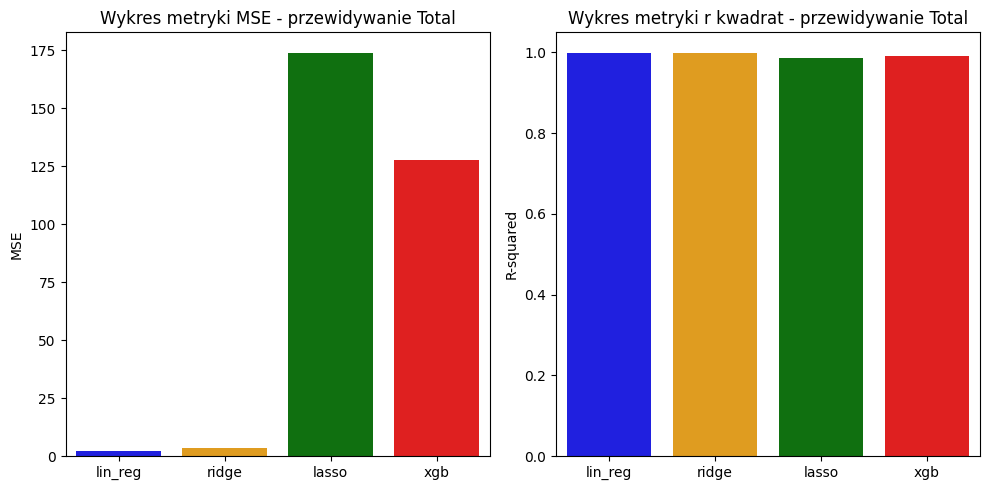

In [177]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
color_palette = ["blue", "orange", "green", "red"]

axes[0].set_title("Wykres metryki MSE - przewidywanie Total")
sns.barplot(df_total_scores.loc['MSE'], palette=color_palette, ax=axes[0])

plt.title("Wykres metryki r kwadrat - przewidywanie Total")
sns.barplot(df_total_scores.loc['R-squared'], palette=color_palette, ax=axes[1])

plt.tight_layout()
plt.show()

#### PCA

In [181]:
df_lasso_reg_pca[10] = scores_total["lasso"]
df_lasso_reg_pca["type"] = ["lasso", "lasso"]
df_lin_reg_pca[10] = scores_total["lin_reg"]
df_lin_reg_pca["type"] = ["lin_reg", "lin_reg"]
df_xgb_reg_pca[10] = scores_total["xgb"]
df_xgb_reg_pca["type"] = ["xgb", "xgb"]
df_ridge_reg_pca[10] = scores_total["ridge"]
df_ridge_reg_pca["type"] = ["ridge", "ridge"]

df_full_scores_total = pd.concat([df_ridge_reg_pca, df_xgb_reg_pca, df_lasso_reg_pca, df_lin_reg_pca])
df_full_scores_total["metric"] = df_full_scores_total.index
df_full_scores_total.set_index(["type", "metric"])

2          4         6         8        10
type    metric                                                        
ridge   MSE        12952.9216  1001.9875  365.6994  153.7005    3.4730
        R-squared      0.0085     0.9233    0.9720    0.9882    0.9997
xgb     MSE          206.4147    30.2405   39.4272   56.3285  127.6226
        R-squared      0.9842     0.9977    0.9970    0.9957    0.9902
lasso   MSE        12952.4669  1026.6236  458.6463  403.3173  174.0233
        R-squared      0.0085     0.9214    0.9649    0.9691    0.9867
lin_reg MSE          152.4775   152.4775  152.4775  152.4775    2.0923
        R-squared      0.9883     0.9883    0.9883    0.9883    0.9998

Jak można zauważyć wszystkie metody oprócz xgb utraciły na wykorzystaniu redukcji wymiarowości. Natomiast metoda xgb zyskała na redukcji cech do 4 (został zanotowany znaczący spadek błędu).

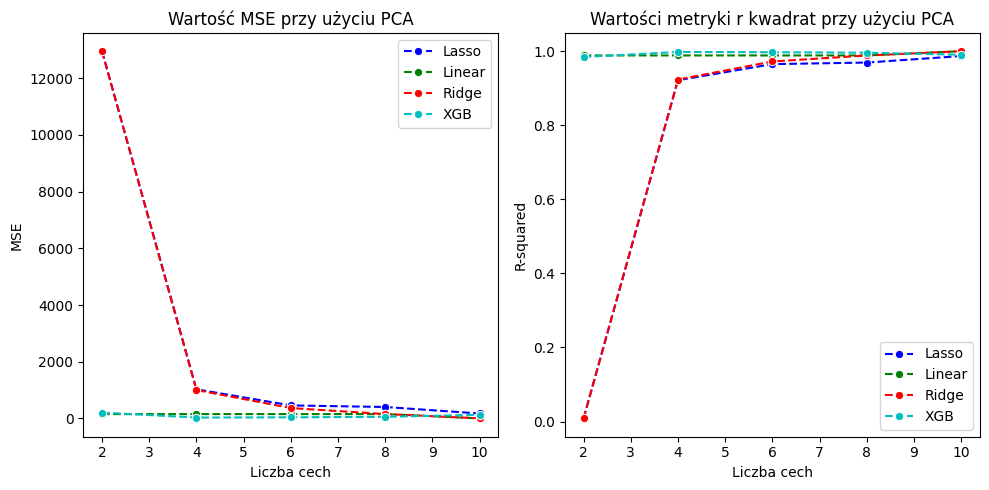

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title("Wartość MSE przy użyciu PCA")
sns.lineplot(data=df_lasso_reg_pca.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='b', label='Lasso', ax=axes[0])
sns.lineplot(data=df_lin_reg_pca.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='g', label='Linear', ax=axes[0])
sns.lineplot(data=df_ridge_reg_pca.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='r', label='Ridge', ax=axes[0])
sns.lineplot(data=df_xgb_reg_pca.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='c', label='XGB', ax=axes[0])
axes[0].set_xlabel("Liczba cech")
axes[0].set_ylabel("MSE")
axes[0].legend()

axes[1].set_title("Wartości metryki r kwadrat przy użyciu PCA")
sns.lineplot(data=df_lasso_reg_pca.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='b', label='Lasso', ax=axes[1])
sns.lineplot(data=df_lin_reg_pca.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='g', label='Linear', ax=axes[1])
sns.lineplot(data=df_ridge_reg_pca.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='r', label='Ridge', ax=axes[1])
sns.lineplot(data=df_xgb_reg_pca.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='c', label='XGB', ax=axes[1])
axes[1].set_xlabel("Liczba cech")
axes[1].set_ylabel("R-squared")
axes[1].legend()

plt.tight_layout()
plt.show()

#### t-SNE

In [182]:
df_lasso_reg_tsne[10] = scores_total["lasso"]
df_lasso_reg_tsne["type"] = ["lasso", "lasso"]
df_lin_reg_tsne[10] = scores_total["lin_reg"]
df_lin_reg_tsne["type"] = ["lin_reg", "lin_reg"]
df_xgb_reg_tsne[10] = scores_total["xgb"]
df_xgb_reg_tsne["type"] = ["xgb", "xgb"]
df_ridge_reg_tsne[10] = scores_total["ridge"]
df_ridge_reg_tsne["type"] = ["ridge", "ridge"]

df_full_scores_total_tsne = pd.concat([df_lasso_reg_tsne, df_lin_reg_tsne, df_xgb_reg_tsne, df_ridge_reg_tsne])
df_full_scores_total_tsne["metric"] = df_full_scores_total.index
df_full_scores_total_tsne.set_index(["type", "metric"])

2           4           6           8        10
type    metric                                                             
lasso   MSE        13029.0321  11257.0628  11648.0144  11927.4010  174.0233
        R-squared      0.0026      0.1383      0.1084      0.0870    0.9867
lin_reg MSE        13028.9040  11256.9394  11672.9256  11986.6531    2.0923
        R-squared      0.0027      0.1383      0.1065      0.0824    0.9998
xgb     MSE        19607.4963  12812.8694  14148.4082  12592.9818  127.6226
        R-squared     -0.5009      0.0192     -0.0830      0.0360    0.9902
ridge   MSE        13028.9040  11256.9408  11672.8917  11986.5139    3.4730
        R-squared      0.0027      0.1383      0.1065      0.0824    0.9997

Jak można zauważyć wyniki przy pomocy redukcji t-SNE są o wiele gorsze niż przy pomocy wszystkich cech czy też przy pomocy redukcji PCA. Dlatego raczej redukcję za pomocą t-SNE nalezy odrzucić. Trzeba również pamiętać o tym, że t-SNE jest o wiele dłuższą metodą. 

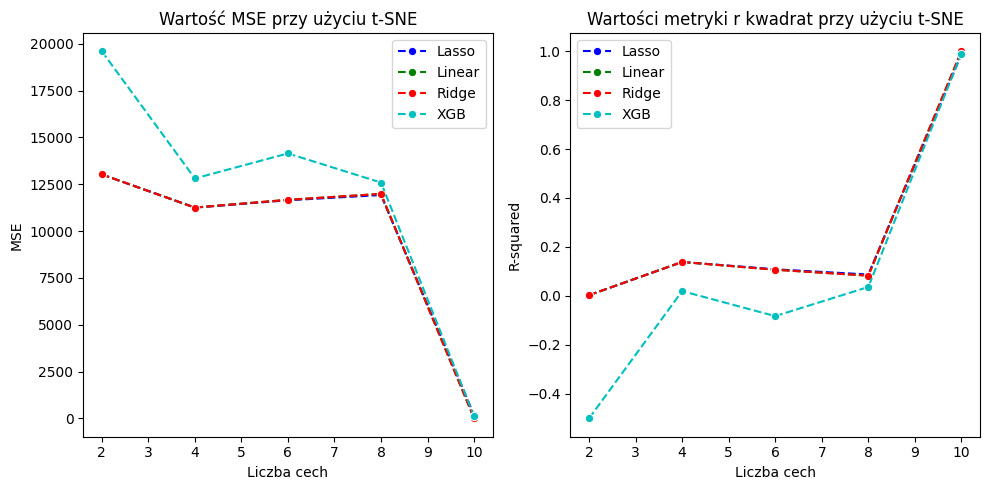

In [183]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title("Wartość MSE przy użyciu t-SNE")
sns.lineplot(data=df_lasso_reg_tsne.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='b', label='Lasso', ax=axes[0])
sns.lineplot(data=df_lin_reg_tsne.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='g', label='Linear', ax=axes[0])
sns.lineplot(data=df_ridge_reg_tsne.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='r', label='Ridge', ax=axes[0])
sns.lineplot(data=df_xgb_reg_tsne.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='c', label='XGB', ax=axes[0])
axes[0].set_xlabel("Liczba cech")
axes[0].set_ylabel("MSE")
axes[0].legend()

axes[1].set_title("Wartości metryki r kwadrat przy użyciu t-SNE")
sns.lineplot(data=df_lasso_reg_tsne.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='b', label='Lasso', ax=axes[1])
sns.lineplot(data=df_lin_reg_tsne.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='g', label='Linear', ax=axes[1])
sns.lineplot(data=df_ridge_reg_tsne.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='r', label='Ridge', ax=axes[1])
sns.lineplot(data=df_xgb_reg_tsne.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='c', label='XGB', ax=axes[1])
axes[1].set_xlabel("Liczba cech")
axes[1].set_ylabel("R-squared")
axes[1].legend()

plt.tight_layout()
plt.show()

## Regresja dla zmiennej HP

### Podział danych

In [59]:
scores_hp = {}
X_train, y_train = train_df.drop('HP', axis=1), train_clean.HP
X_test, y_test = test_df.drop('HP', axis=1), test_clean.HP

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3308, 10) (3308,)
(2541, 10) (2541,)


In [16]:
X_train_tsne_dict = {}
X_test_tsne_dict = {}
for k in [2, 4, 6, 8]:
    start = time.time()
    tsne = TSNE(n_components=k, method='exact', n_jobs=-1)
    X_train_tsne = tsne.fit_transform(X_train)
    X_test_tsne = tsne.fit_transform(X_test)
    X_train_tsne_dict[k] = X_train_tsne
    X_test_tsne_dict[k] = X_test_tsne
    stop = time.time()
    print(f"Liczba cech: {k} - czas: {stop - start} sec")

Liczba cech: 2 - czas: 283.8439884185791 sec
Liczba cech: 4 - czas: 433.8127236366272 sec
Liczba cech: 6 - czas: 456.01336550712585 sec
Liczba cech: 8 - czas: 465.06859278678894 sec


### Regresja liniowa

In [125]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [126]:
y_pred = lin_reg.predict(X_test)
scores_hp["lin_reg"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_hp["lin_reg"][0]}")
print(f"R-squared: {scores_hp["lin_reg"][1]}")

MSE: 2.092600107192993
R-squared: 0.9972


#### PCA

In [20]:
scores_hp_pca = {}
for k in [2, 4, 6, 8]:
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_pca, y_train)
    y_pred = lin_reg.predict(X_test_pca)
    scores_hp_pca[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_hp_pca[k][0]}", end=' ')
    print(f"R-squared: {scores_hp_pca[k][1]}, liczba cech po redukcji {k}")

MSE: 743.3103 R-squared: 0.0146, liczba cech po redukcji 2
MSE: 565.8861 R-squared: 0.2498, liczba cech po redukcji 4
MSE: 484.409 R-squared: 0.3578, liczba cech po redukcji 6
MSE: 439.6408 R-squared: 0.4172, liczba cech po redukcji 8


In [21]:
df_lin_reg_pca = pd.DataFrame(scores_hp_pca)
df_lin_reg_pca.index = ['MSE', 'R-squared']
df_lin_reg_pca

,2,4,6,8
MSE,743.3103,565.8861,484.4090,439.6408
R-squared,0.0146,0.2498,0.3578,0.4172


#### t-SNE

In [22]:
scores_hp_tsne = {}
for k, (X_train_tsne, X_test_tsne) in zip(X_train_tsne_dict.keys(), zip(X_train_tsne_dict.values(), X_test_tsne_dict.values())):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_tsne, y_train)
    y_pred = lin_reg.predict(X_test_tsne)
    scores_hp_tsne[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), 
                            np.round(r2_score(y_true=y_test, y_pred=y_pred), 4))
    print(f"MSE: {scores_hp_tsne[k][0]}", end=' ')
    print(f"R-squared: {scores_hp_tsne[k][1]}, liczba cech po redukcji {k}")

MSE: 749.9949 R-squared: 0.0057, liczba cech po redukcji 2
MSE: 723.1805 R-squared: 0.0413, liczba cech po redukcji 4
MSE: 728.0228 R-squared: 0.0349, liczba cech po redukcji 6
MSE: 740.5594 R-squared: 0.0182, liczba cech po redukcji 8


In [23]:
df_lin_reg_tsne = pd.DataFrame(scores_hp_tsne)
df_lin_reg_tsne.index = ['MSE', 'R-squared']
df_lin_reg_tsne

,2,4,6,8
MSE,749.9949,723.1805,728.0228,740.5594
R-squared,0.0057,0.0413,0.0349,0.0182


### Regresja grzbietowa

In [127]:
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

Ridge()

In [128]:
y_pred = ridge_reg.predict(X_test)
scores_hp["ridge"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_hp['ridge'][0]}")
print(f"R-squared: {scores_hp['ridge'][1]}")

MSE: 32.7919
R-squared: 0.9565


#### PCA

In [24]:
scores_hp_pca = {}
for k in [2, 4, 6, 8]:
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    ridge_reg = Ridge()
    ridge_reg.fit(X_train_pca, y_train)
    y_pred = ridge_reg.predict(X_test_pca)
    scores_hp_pca[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_hp_pca[k][0]}", end=' ')
    print(f"R-squared: {scores_hp_pca[k][1]}, liczba cech po redukcji {k}")

MSE: 743.3103 R-squared: 0.0146, liczba cech po redukcji 2
MSE: 565.9199 R-squared: 0.2498, liczba cech po redukcji 4
MSE: 484.5173 R-squared: 0.3577, liczba cech po redukcji 6
MSE: 439.7038 R-squared: 0.4171, liczba cech po redukcji 8


In [29]:
df_ridge_reg_pca = pd.DataFrame(scores_hp_pca)
df_ridge_reg_pca.index = ['MSE', 'R-squared']
df_ridge_reg_pca

,2,4,6,8
MSE,743.3103,565.9199,484.5173,439.7038
R-squared,0.0146,0.2498,0.3577,0.4171


#### t-SNE

In [26]:
scores_hp_tsne = {}
for k, (X_train_tsne, X_test_tsne) in zip(X_train_tsne_dict.keys(), zip(X_train_tsne_dict.values(), X_test_tsne_dict.values())):
    ridge_reg = Ridge()
    ridge_reg.fit(X_train_tsne, y_train)
    y_pred = ridge_reg.predict(X_test_tsne)
    scores_hp_tsne[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_hp_tsne[k][0]}", end=' ')
    print(f"R-squared: {scores_hp_tsne[k][1]}, liczba cech po redukcji {k}")

MSE: 749.9949 R-squared: 0.0057, liczba cech po redukcji 2
MSE: 723.1805 R-squared: 0.0413, liczba cech po redukcji 4
MSE: 728.0192 R-squared: 0.0349, liczba cech po redukcji 6
MSE: 740.5493 R-squared: 0.0183, liczba cech po redukcji 8


In [28]:
df_ridge_reg_tsne = pd.DataFrame(scores_hp_tsne)
df_ridge_reg_tsne.index = ['MSE', 'R-squared']
df_ridge_reg_tsne

,2,4,6,8
MSE,749.9949,723.1805,728.0192,740.5493
R-squared,0.0057,0.0413,0.0349,0.0183


### Lasso

In [129]:
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

Lasso()

In [130]:
y_pred = lasso_reg.predict(X_test)
scores_hp["lasso"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_hp['lasso'][0]}")
print(f"R-squared: {scores_hp['lasso'][1]}")

MSE: 506.1958
R-squared: 0.3289


#### PCA

In [30]:
scores_hp_pca = {}
for k in [2, 4, 6, 8]:
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    lasso_reg = Lasso()
    lasso_reg.fit(X_train_pca, y_train)
    y_pred = lasso_reg.predict(X_test_pca)
    scores_hp_pca[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_hp_pca[k][0]}", end=' ')
    print(f"R-squared: {scores_hp_pca[k][1]}, liczba cech po redukcji {k}")

MSE: 743.5515 R-squared: 0.0143, liczba cech po redukcji 2
MSE: 577.5633 R-squared: 0.2343, liczba cech po redukcji 4
MSE: 562.4576 R-squared: 0.2543, liczba cech po redukcji 6
MSE: 562.4576 R-squared: 0.2543, liczba cech po redukcji 8


In [31]:
df_lasso_reg_pca = pd.DataFrame(scores_hp_pca)
df_lasso_reg_pca.index = ['MSE', 'R-squared']
df_lasso_reg_pca

,2,4,6,8
MSE,743.5515,577.5633,562.4576,562.4576
R-squared,0.0143,0.2343,0.2543,0.2543


#### t-SNE

In [32]:
scores_hp_tsne = {}
for k, (X_train_tsne, X_test_tsne) in zip(X_train_tsne_dict.keys(), zip(X_train_tsne_dict.values(), X_test_tsne_dict.values())):
    lasso_reg = Lasso()
    lasso_reg.fit(X_train_tsne, y_train)
    y_pred = lasso_reg.predict(X_test_tsne)
    scores_hp_tsne[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_hp_tsne[k][0]}", end=' ')
    print(f"R-squared: {scores_hp_tsne[k][1]}, liczba cech po redukcji {k}")

MSE: 749.9977 R-squared: 0.0057, liczba cech po redukcji 2
MSE: 722.7095 R-squared: 0.0419, liczba cech po redukcji 4
MSE: 722.8771 R-squared: 0.0417, liczba cech po redukcji 6
MSE: 731.2335 R-squared: 0.0306, liczba cech po redukcji 8


In [33]:
df_lasso_reg_tsne = pd.DataFrame(scores_total_tsne)
df_lasso_reg_tsne.index = ['MSE', 'R-squared']
df_lasso_reg_tsne

,2,4,6,8
MSE,749.9949,723.1805,728.0228,740.5594
R-squared,0.0057,0.0413,0.0349,0.0182


### Regresja xgboost

In [131]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [132]:
y_pred = xgb_reg.predict(X_test)
scores_hp["xgb"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_hp["xgb"][0]}")
print(f"R-squared: {scores_hp["xgb"][1]}")

MSE: 27.28860092163086
R-squared: 0.9638


#### PCA

In [34]:
scores_hp_pca = {}
for k in [2, 4, 6, 8]:
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    xgb_reg = xgb.XGBRegressor()
    xgb_reg.fit(X_train_pca, y_train)
    y_pred = xgb_reg.predict(X_test_pca)
    scores_hp_pca[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_hp_pca[k][0]}", end=' ')
    print(f"R-squared: {scores_hp_pca[k][1]}, liczba cech po redukcji {k}")

MSE: 55.7387 R-squared: 0.9261, liczba cech po redukcji 2
MSE: 38.5059 R-squared: 0.949, liczba cech po redukcji 4
MSE: 71.1435 R-squared: 0.9057, liczba cech po redukcji 6
MSE: 79.1462 R-squared: 0.8951, liczba cech po redukcji 8


In [35]:
df_xgb_reg_pca = pd.DataFrame(scores_hp_pca)
df_xgb_reg_pca.index = ['MSE', 'R-squared']
df_xgb_reg_pca

,2,4,6,8
MSE,55.7387,38.5059,71.1435,79.1462
R-squared,0.9261,0.9490,0.9057,0.8951


#### t-SNE

In [36]:
scores_hp_tsne = {}
for k, (X_train_tsne, X_test_tsne) in zip(X_train_tsne_dict.keys(), zip(X_train_tsne_dict.values(), X_test_tsne_dict.values())):
    xgb_reg = xgb.XGBRegressor()
    xgb_reg.fit(X_train_tsne, y_train)
    y_pred = xgb_reg.predict(X_test_tsne)
    scores_hp_tsne[k] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
    print(f"MSE: {scores_hp_tsne[k][0]}", end=' ')
    print(f"R-squared: {scores_hp_tsne[k][1]}, liczba cech po redukcji {k}")

MSE: 1313.0316 R-squared: -0.7407, liczba cech po redukcji 2
MSE: 896.9033 R-squared: -0.189, liczba cech po redukcji 4
MSE: 867.9155 R-squared: -0.1506, liczba cech po redukcji 6
MSE: 687.7664 R-squared: 0.0882, liczba cech po redukcji 8


In [37]:
df_xgb_reg_tsne = pd.DataFrame(scores_hp_tsne)
df_xgb_reg_tsne.index = ['MSE', 'R-squared']
df_xgb_reg_tsne

,2,4,6,8
MSE,1313.0316,896.9033,867.9155,687.7664
R-squared,-0.7407,-0.1890,-0.1506,0.0882


### Sieć neuronowa

#### Zdefiniowanie klasy sieci neuronowej

In [85]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size=1):
        super(NeuralNetwork, self).__init__()
    
        layers = []
        prev_size = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        return self.linear_relu_stack(x)

X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Zdefiniowanie funkcji treningu oraz testowania

In [78]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


def test(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            predictions = model(X_batch)
            loss = criterion(predictions.squeeze(), y_batch)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [ ]:
model = NeuralNetwork(10, [64, 128, 64])
lr = 5e-4
num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    test_loss = test(model, test_dataloader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

#### Dostrajanie hiperparametrów

In [109]:
errors_table = {
        "liczba_warstw" : [],
        "wielkosci_warstw" : [],
        "liczba_epok" : [],
        "współczynnik_uczenia": [],
        "błąd": []
}
def objective(trial):
    params = {
        "liczba_warstw" : trial.suggest_int("liczba_warstw", low=1, high=10),
        "wielkosci_warstw" : trial.suggest_int("wielkość_warstw", low=1, high=256),
        "liczba_epok" : trial.suggest_int("liczba_epok", low=1, high=300),
        "współczynnik_uczenia": trial.suggest_float("wspołczynnik_uczenia", low=5e-6, high=5e-2)
    }
    warstwy = [params["wielkosci_warstw"] for _ in range(params["liczba_warstw"])]
    model = NeuralNetwork(10, warstwy)
    lr = params["współczynnik_uczenia"]
    num_epochs = params["liczba_epok"]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        train_loss = train(model, train_dataloader, optimizer, criterion)
        test_loss = test(model, test_dataloader, criterion)

    errors_table["liczba_warstw"].append(params["liczba_warstw"])
    errors_table["wielkosci_warstw"].append(params["wielkosci_warstw"])
    errors_table["liczba_epok"].append(params["liczba_epok"])
    errors_table["współczynnik_uczenia"].append(params["współczynnik_uczenia"])
    errors_table["błąd"].append(test_loss)
    return test_loss

In [110]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best params: ", study.best_params)
print("Best value: ", study.best_value)

[I 2025-01-09 10:09:44,375] A new study created in memory with name: no-name-3bb0cf3f-47e5-43e1-afb6-6c13eca3d2c1
Training Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:10<00:00,  8.58it/s]
[I 2025-01-09 10:09:54,868] Trial 0 finished with value: 73.17571468353272 and parameters: {'liczba_warstw': 1, 'wielkość_warstw': 187, 'liczba_epok': 90, 'wspołczynnik_uczenia': 0.0034926878839725466}. Best is trial 0 with value: 73.17571468353272.
Training Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.68it/s]
[I 2025-01-09 10:10:08,578] Trial 1 finished with value: 18.253554940223694 and parameters: {'liczba_warstw': 1, 'wielkość_warstw': 158, 'liczba_epok': 119, 'wspołczynnik_uczenia': 0.0021423280108491885}. Best is trial 1 with value: 18.253554940223694.
Training Progress: 100%|█████████████████████████████████████

Best params:  {'liczba_warstw': 1, 'wielkość_warstw': 145, 'liczba_epok': 261, 'wspołczynnik_uczenia': 0.03175756996056571}
Best value:  1.2765763953328133


In [113]:
df_error_table = pd.DataFrame(errors_table)
df_error_table.sort_values("błąd").head()

,liczba_warstw,wielkosci_warstw,liczba_epok,współczynnik_uczenia,błąd
22,1,145,261,0.031758,1.276576
21,1,194,258,0.031703,1.388617
20,1,198,258,0.030629,1.454783
30,2,144,180,0.039586,1.572315
6,3,244,195,0.032013,1.645952


In [123]:
scores_hp["nn"] = (np.round(df_error_table.sort_values("błąd")["błąd"][22], 4), 0)

In [124]:
scores_hp

{'nn': (np.float64(1.2766), 0)}

#### PCA

In [143]:
X_train

tensor([[-76.7589,  -2.9263],
        [-22.7689,  -4.3374],
        [ 50.1748,  -8.8040],
        ...,
        [-76.7589,  -2.9265],
        [ 20.2367,  -3.6648],
        [ 11.2151,  -3.5072]])

In [149]:
scores_hp_pca = {}
for k in [2, 4, 6, 8]:
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    X_train_pca = torch.tensor(X_train_pca, dtype=torch.float32)
    X_test_pca = torch.tensor(X_test_pca, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train_pca, y_train)
    test_dataset = TensorDataset(X_test_pca, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    model = NeuralNetwork(k, [145])
    lr = 0.031758
    num_epochs = 261
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        train_loss = train(model, train_dataloader, optimizer, criterion)
        test_loss = test(model, test_dataloader, criterion)
    scores_hp_pca[k] = (np.round(test_loss, 4), 0)
    print(f"MSE: {scores_hp_pca[k][0]}")

Training Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:29<00:00,  8.84it/s]


MSE: 709.7001


Training Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:29<00:00,  8.90it/s]


MSE: 310.6279


Training Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:30<00:00,  8.64it/s]


MSE: 180.6013


Training Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:29<00:00,  8.79it/s]

MSE: 80.3009


In [150]:
df_nn_reg_pca = pd.DataFrame(scores_hp_pca)
df_nn_reg_pca.index = ['MSE', 'R-squared']
df_nn_reg_pca

,2,4,6,8
MSE,709.7001,310.6279,180.6013,80.3009
R-squared,0.0000,0.0000,0.0000,0.0000


#### t-SNE

In [151]:
scores_hp_tsne = {}
for k, (X_train_tsne, X_test_tsne) in zip(X_train_tsne_dict.keys(), zip(X_train_tsne_dict.values(), X_test_tsne_dict.values())):
    X_train_tsne = torch.tensor(X_train_tsne, dtype=torch.float32)
    X_test_tsne = torch.tensor(X_test_tsne, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train_tsne, y_train)
    test_dataset = TensorDataset(X_test_tsne, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    model = NeuralNetwork(k, [145])
    lr = 0.031758
    num_epochs = 261
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        train_loss = train(model, train_dataloader, optimizer, criterion)
        test_loss = test(model, test_dataloader, criterion)
    scores_hp_tsne[k] = (np.round(test_loss, 4), 0)
    print(f"MSE: {scores_hp_tsne[k][0]}")

Training Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:30<00:00,  8.65it/s]


MSE: 756.7044


Training Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:30<00:00,  8.64it/s]


MSE: 1552.7293


Training Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:30<00:00,  8.48it/s]


MSE: 1240.1847


Training Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:31<00:00,  8.38it/s]

MSE: 1620.7932


In [152]:
df_nn_reg_tsne = pd.DataFrame(scores_hp_tsne)
df_nn_reg_tsne.index = ['MSE', 'R-squared']
df_nn_reg_tsne

,2,4,6,8
MSE,756.7044,1552.7293,1240.1847,1620.7932
R-squared,0.0000,0.0000,0.0000,0.0000


### Podsumowanie

In [133]:
train_data["HP"].max()

np.int64(255)

In [134]:
df_hp_scores = pd.DataFrame(scores_hp)
df_hp_scores.index = ['MSE', 'R-squared']
df_hp_scores

,nn,lin_reg,ridge,lasso,xgb
MSE,1.2766,2.0926,32.7919,506.1958,27.288601
R-squared,0.0000,0.9972,0.9565,0.3289,0.963800


Dla przewidywania zmiennej HP najlepszą metodą jest liniowa regresja, która zdecydowanie odbiega od innych metod. Nastepnie regresja grzbietowa oraz metoda xgb wypadły średnio. Najgorzej wypadła metoda Lasso, która prawdopobnie zwracała kompletne głupoty. Warto wspomnieć że wartości zmiennej HP wahały się od 0 do 255. Podsumowując, do tej pory najlepszą metodą okazała się regresja liniowa, która w obu przypadkach wypadła najlepiej. - jak widać po dodatkowym wykorzystaniu sieci neuronowych wypadły one najlepiej.

C:\Users\urbii\AppData\Local\Temp\ipykernel_3332\3634349615.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_hp_scores.loc['MSE'], palette=color_palette, ax=axes[0])
C:\Users\urbii\AppData\Local\Temp\ipykernel_3332\3634349615.py:5: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(df_hp_scores.loc['MSE'], palette=color_palette, ax=axes[0])
C:\Users\urbii\AppData\Local\Temp\ipykernel_3332\3634349615.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_hp_scores.loc['R-squared'], palette=color_palette, ax=axes[1])
C:\Users\urbii\AppData\Local\Temp\ipykernel_3332\3634349615.py:8: UserWarning: 
T

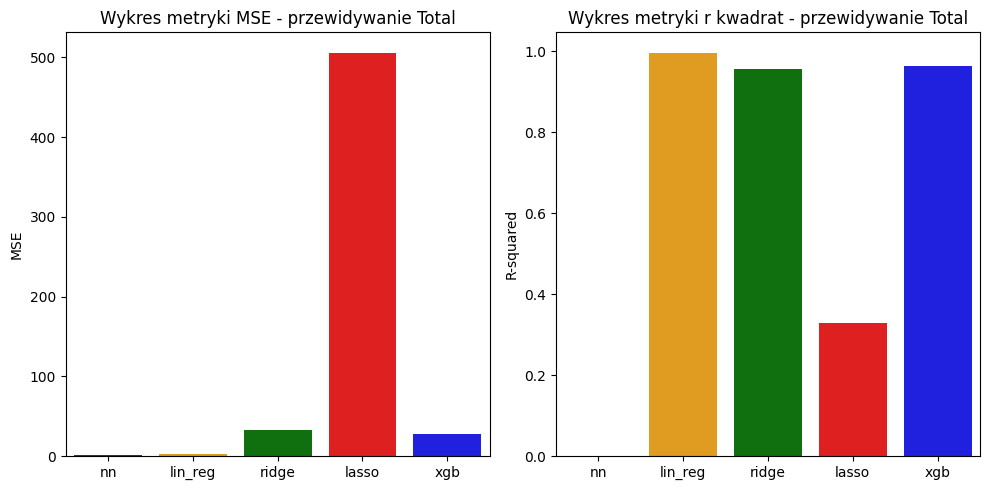

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
color_palette = ["blue", "orange", "green", "red"]

axes[0].set_title("Wykres metryki MSE - przewidywanie Total")
sns.barplot(df_hp_scores.loc['MSE'], palette=color_palette, ax=axes[0])

plt.title("Wykres metryki r kwadrat - przewidywanie Total")
sns.barplot(df_hp_scores.loc['R-squared'], palette=color_palette, ax=axes[1])

plt.tight_layout()
plt.show()

#### PCA

In [155]:
df_lasso_reg_pca[10] = scores_hp["lasso"]
df_lasso_reg_pca["type"] = ["lasso", "lasso"]
df_lin_reg_pca[10] = scores_hp["lin_reg"]
df_lin_reg_pca["type"] = ["lin_reg", "lin_reg"]
df_xgb_reg_pca[10] = scores_hp["xgb"]
df_xgb_reg_pca["type"] = ["xgb", "xgb"]
df_ridge_reg_pca[10] = scores_hp["ridge"]
df_ridge_reg_pca["type"] = ["ridge", "ridge"]
df_nn_reg_pca[10] = scores_hp["nn"]
df_nn_reg_pca["type"] = ["nn", "nn"]

df_full_scores_hp = pd.concat([df_ridge_reg_pca, df_xgb_reg_pca, df_lasso_reg_pca, df_lin_reg_pca, df_nn_reg_pca])
df_full_scores_hp["metric"] = df_full_scores_hp.index
df_full_scores_hp.set_index(["type", "metric"])

2         4         6         8          10
type    metric                                                       
ridge   MSE        743.3103  565.9199  484.5173  439.7038   32.791900
        R-squared    0.0146    0.2498    0.3577    0.4171    0.956500
xgb     MSE         55.7387   38.5059   71.1435   79.1462   27.288601
        R-squared    0.9261    0.9490    0.9057    0.8951    0.963800
lasso   MSE        743.5515  577.5633  562.4576  562.4576  506.195800
        R-squared    0.0143    0.2343    0.2543    0.2543    0.328900
lin_reg MSE        743.3103  565.8861  484.4090  439.6408    2.092600
        R-squared    0.0146    0.2498    0.3578    0.4172    0.997200
nn      MSE        709.7001  310.6279  180.6013   80.3009    1.276600
        R-squared    0.0000    0.0000    0.0000    0.0000    0.000000

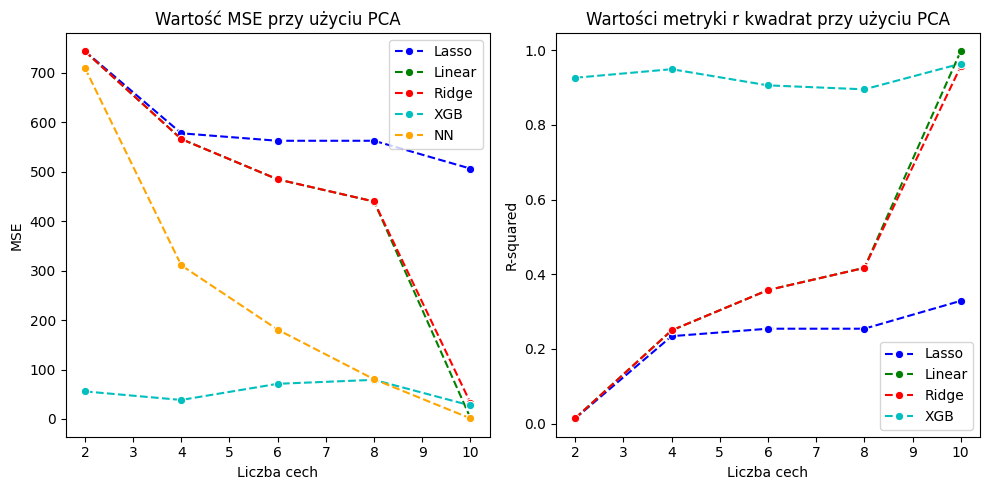

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title("Wartość MSE przy użyciu PCA")
sns.lineplot(data=df_lasso_reg_pca.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='b', label='Lasso', ax=axes[0])
sns.lineplot(data=df_lin_reg_pca.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='g', label='Linear', ax=axes[0])
sns.lineplot(data=df_ridge_reg_pca.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='r', label='Ridge', ax=axes[0])
sns.lineplot(data=df_xgb_reg_pca.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='c', label='XGB', ax=axes[0])
sns.lineplot(data=df_nn_reg_pca.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='orange', label='NN', ax=axes[0])
axes[0].set_xlabel("Liczba cech")
axes[0].set_ylabel("MSE")
axes[0].legend()

axes[1].set_title("Wartości metryki r kwadrat przy użyciu PCA")
sns.lineplot(data=df_lasso_reg_pca.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='b', label='Lasso', ax=axes[1])
sns.lineplot(data=df_lin_reg_pca.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='g', label='Linear', ax=axes[1])
sns.lineplot(data=df_ridge_reg_pca.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='r', label='Ridge', ax=axes[1])
sns.lineplot(data=df_xgb_reg_pca.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='c', label='XGB', ax=axes[1])
axes[1].set_xlabel("Liczba cech")
axes[1].set_ylabel("R-squared")
axes[1].legend()

plt.tight_layout()
plt.show()

#### t-SNE

In [160]:
df_lasso_reg_tsne[10] = scores_hp["lasso"]
df_lasso_reg_tsne["type"] = ["lasso", "lasso"]
df_lin_reg_tsne[10] = scores_hp["lin_reg"]
df_lin_reg_tsne["type"] = ["lin_reg", "lin_reg"]
df_xgb_reg_tsne[10] = scores_hp["xgb"]
df_xgb_reg_tsne["type"] = ["xgb", "xgb"]
df_ridge_reg_tsne[10] = scores_hp["ridge"]
df_ridge_reg_tsne["type"] = ["ridge", "ridge"]
df_nn_reg_tsne[10] = scores_hp["nn"]
df_nn_reg_tsne["type"] = ["nn", "nn"]

df_full_scores_hp_tsne = pd.concat([df_lasso_reg_tsne, df_lin_reg_tsne, df_xgb_reg_tsne, df_ridge_reg_tsne, df_nn_reg_tsne])
df_full_scores_hp_tsne["metric"] = df_full_scores_hp_tsne.index
df_full_scores_hp_tsne.set_index(["type", "metric"])

2          4          6          8          10
type    metric                                                           
lasso   MSE         749.9949   723.1805   728.0228   740.5594  506.195800
        R-squared     0.0057     0.0413     0.0349     0.0182    0.328900
lin_reg MSE         749.9949   723.1805   728.0228   740.5594    2.092600
        R-squared     0.0057     0.0413     0.0349     0.0182    0.997200
xgb     MSE        1313.0316   896.9033   867.9155   687.7664   27.288601
        R-squared    -0.7407    -0.1890    -0.1506     0.0882    0.963800
ridge   MSE         749.9949   723.1805   728.0192   740.5493   32.791900
        R-squared     0.0057     0.0413     0.0349     0.0183    0.956500
nn      MSE         756.7044  1552.7293  1240.1847  1620.7932    1.276600
        R-squared     0.0000     0.0000     0.0000     0.0000    0.000000

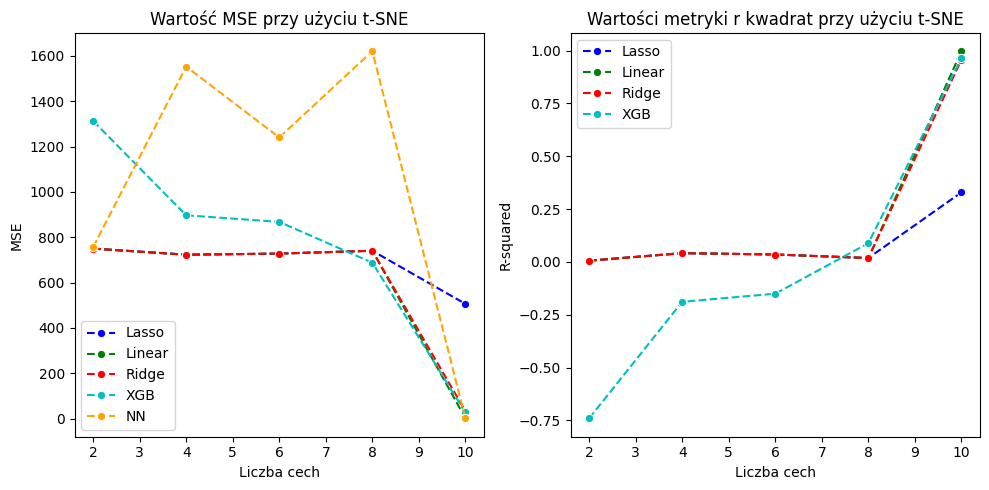

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title("Wartość MSE przy użyciu t-SNE")
sns.lineplot(data=df_lasso_reg_tsne.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='b', label='Lasso', ax=axes[0])
sns.lineplot(data=df_lin_reg_tsne.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='g', label='Linear', ax=axes[0])
sns.lineplot(data=df_ridge_reg_tsne.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='r', label='Ridge', ax=axes[0])
sns.lineplot(data=df_xgb_reg_tsne.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='c', label='XGB', ax=axes[0])
sns.lineplot(data=df_nn_reg_tsne.drop("type", axis=1).loc['MSE'], 
             marker='o', linestyle='--', color='orange', label='NN', ax=axes[0])
axes[0].set_xlabel("Liczba cech")
axes[0].set_ylabel("MSE")
axes[0].legend()

axes[1].set_title("Wartości metryki r kwadrat przy użyciu t-SNE")
sns.lineplot(data=df_lasso_reg_tsne.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='b', label='Lasso', ax=axes[1])
sns.lineplot(data=df_lin_reg_tsne.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='g', label='Linear', ax=axes[1])
sns.lineplot(data=df_ridge_reg_tsne.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='r', label='Ridge', ax=axes[1])
sns.lineplot(data=df_xgb_reg_tsne.drop("type", axis=1).loc['R-squared'], 
             marker='o', linestyle='--', color='c', label='XGB', ax=axes[1])
axes[1].set_xlabel("Liczba cech")
axes[1].set_ylabel("R-squared")
axes[1].legend()

plt.tight_layout()
plt.show()

## Klasyfikacja nazw pokemonów

### Podział danych

In [289]:
scores_name = {}
X_train, y_train = train_df.drop('Name', axis=1), train_df.Name
X_test, y_test = test_df.drop('Name', axis=1), test_df.Name

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3308, 10) (3308,)
(2541, 10) (2541,)


### Las losowy

In [262]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [263]:
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
scores_name["rf"] = np.round(accuracy, 3)
scores_name

{'nn': np.float64(0.007), 'rf': np.float64(0.998)}

#### PCA

In [179]:
scores_name_pca = {}
for k in [2, 3]:
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train_pca, y_train)
    y_pred = rf_clf.predict(X_test_pca)
    scores_name_pca[f"{k}"] = accuracy_score(y_pred=y_pred, y_true=y_test)
    print(f"Accuracy: {scores_name_pca[f"{k}"]}")

Accuracy: 0.9358520267611177
Accuracy: 0.9582841401023219


In [182]:
scores_name_pca

{'2': 0.9358520267611177, '3': 0.9582841401023219}

In [187]:
df_rf_clf_pca = pd.Series(scores_name_pca)
df_rf_clf_pca

2    0.935852
3    0.958284
dtype: float64

#### t-SNE

In [189]:
scores_name_tsne = {}
for k in [2, 3]:
    tsne = TSNE(n_components=k)
    X_train_tsne = tsne.fit_transform(X_train)
    X_test_tsne = tsne.fit_transform(X_test)
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train_pca, y_train)
    y_pred = rf_clf.predict(X_test_pca)
    scores_name_tsne[f"{k}"] = accuracy_score(y_pred=y_pred, y_true=y_test)
    print(f"Accuracy: {scores_name_tsne[f"{k}"]}")

Accuracy: 0.9582841401023219
Accuracy: 0.9582841401023219


In [190]:
df_rf_clf_tsne = pd.Series(scores_name_tsne)
df_rf_clf_tsne

2    0.958284
3    0.958284
dtype: float64

### Drzewo decyzyjne

In [264]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [265]:
y_pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
scores_name["dt"] = np.round(accuracy, 3)
scores_name

{'nn': np.float64(0.007), 'rf': np.float64(0.998), 'dt': np.float64(0.983)}

#### PCA

In [194]:
scores_name_pca = {}
for k in [2, 3]:
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    dt_clf = DecisionTreeClassifier()
    dt_clf.fit(X_train_pca, y_train)
    y_pred = dt_clf.predict(X_test_pca)
    scores_name_pca[f"{k}"] = accuracy_score(y_pred=y_pred, y_true=y_test)
    print(f"Accuracy: {scores_name_pca[f"{k}"]}")

Accuracy: 0.922077922077922
Accuracy: 0.9445100354191264


In [195]:
df_dt_clf_pca = pd.Series(scores_name_pca)
df_dt_clf_pca

2    0.922078
3    0.944510
dtype: float64

#### t-SNE

In [196]:
scores_name_tsne = {}
for k in [2, 3]:
    tsne = TSNE(n_components=k)
    X_train_tsne = tsne.fit_transform(X_train)
    X_test_tsne = tsne.fit_transform(X_test)
    dt_clf = DecisionTreeClassifier()
    dt_clf.fit(X_train_pca, y_train)
    y_pred = dt_clf.predict(X_test_pca)
    scores_name_tsne[f"{k}"] = accuracy_score(y_pred=y_pred, y_true=y_test)
    print(f"Accuracy: {scores_name_tsne[f"{k}"]}")

Accuracy: 0.9409681227863046
Accuracy: 0.9421487603305785


In [197]:
df_dt_clf_tsne = pd.Series(scores_name_tsne)
df_dt_clf_tsne

2    0.940968
3    0.942149
dtype: float64

### Sieć neuronowa

In [286]:
class PokemonClassifier(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size=2):
        super(PokemonClassifier, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, output_size))
        layers.append(nn.Softmax(dim=1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [287]:
def train_clf(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


def test_clf(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
            _, predicted = torch.max(predictions, 1)  # Pobierz indeksy klas z największym prawdopodobieństwem
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

In [ ]:
num_epochs = 261
input_size = X_train.shape[1]
hidden_layers = [145]
output_size = y_train.nunique()

model = PokemonClassifier(input_size, hidden_layers, output_size)
lr = 0.031758
num_epochs = 261
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.long)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    train_loss = train_clf(model, train_dataloader, optimizer, criterion)
    test_loss, accuracy = test_clf(model, test_dataloader, criterion)
scores_name["nn"] = np.round(accuracy, 3)

### Podsumowanie

In [266]:
scores_name

{'nn': np.float64(0.007), 'rf': np.float64(0.998), 'dt': np.float64(0.983)}

C:\Users\urbii\AppData\Local\Temp\ipykernel_3332\764206466.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(scores_name, palette=color_palette)
C:\Users\urbii\AppData\Local\Temp\ipykernel_3332\764206466.py:2: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.barplot(scores_name, palette=color_palette)


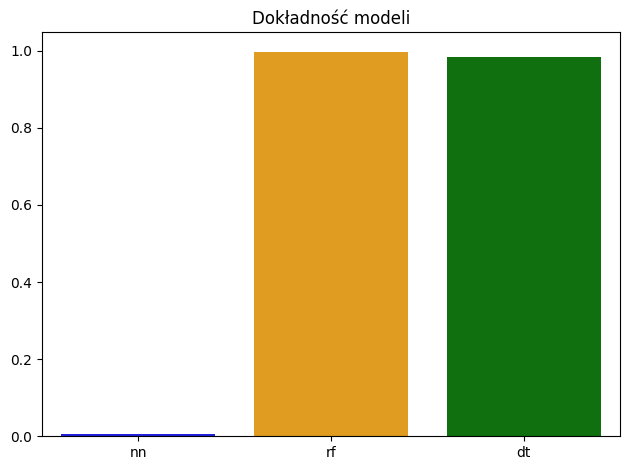

In [267]:
plt.title("Dokładność modeli")
sns.barplot(scores_name, palette=color_palette)
plt.tight_layout()
plt.show()

In [276]:
df_dt_clf_tsne["10"] = scores_name["dt"]
df_rf_clf_tsne["10"] = scores_name["rf"]
print(df_dt_clf_tsne)
df_rf_clf_tsne

2     0.940968
3     0.942149
10    0.983000
dtype: float64


2     0.958284
3     0.958284
10    0.998000
dtype: float64

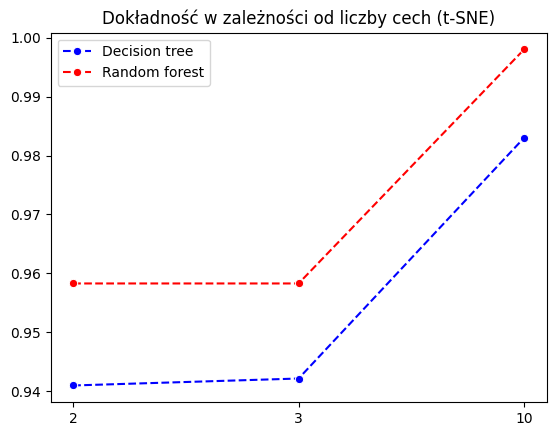

In [285]:
plt.title("Dokładność w zależności od liczby cech (t-SNE)")
sns.lineplot(df_dt_clf_tsne, color='b', marker='o', linestyle='--', label="Decision tree")
sns.lineplot(df_rf_clf_tsne, color='r', marker='o', linestyle='--', label="Random forest")
plt.show()

In [277]:
df_dt_clf_pca["10"] = scores_name["dt"]
df_rf_clf_pca["10"] = scores_name["rf"]
print(df_dt_clf_pca)
df_rf_clf_pca

2     0.922078
3     0.944510
10    0.983000
dtype: float64


2     0.935852
3     0.958284
10    0.998000
dtype: float64

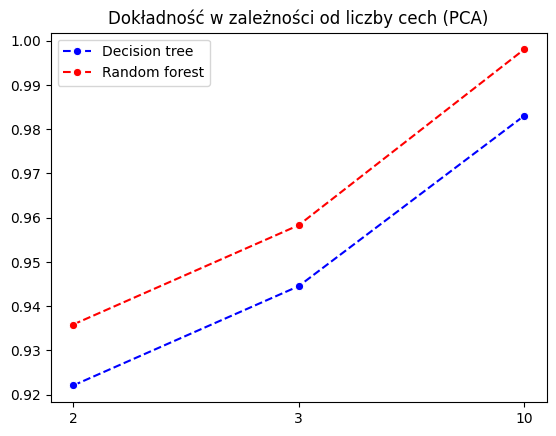

In [284]:
plt.title("Dokładność w zależności od liczby cech (PCA)")
sns.lineplot(df_dt_clf_pca, color='b', marker='o', linestyle='--', label="Decision tree")
sns.lineplot(df_rf_clf_pca, color='r', marker='o', linestyle='--', label="Random forest")
plt.show()

### Wizualizacja cech z t-SNE

In [ ]:
tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_train)

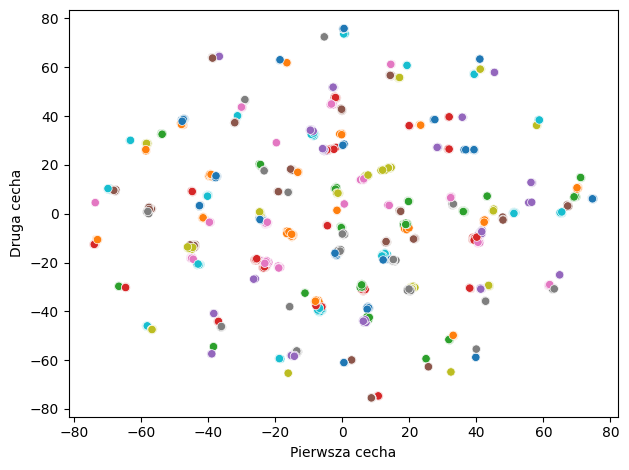

In [212]:
X_train_tsne_df = pd.DataFrame(X_train_tsne, columns=["Dim1", "Dim2"])
X_train_tsne_df["Name"] = y_train
sns.scatterplot(data=X_train_tsne_df, x="Dim1", y="Dim2", hue="Name", palette="tab10", legend=False)
plt.xlabel("Pierwsza cecha")
plt.ylabel("Druga cecha")
plt.tight_layout()
plt.show()

In [215]:
tsne = TSNE(n_components=3)
X_train_tsne = tsne.fit_transform(X_train)

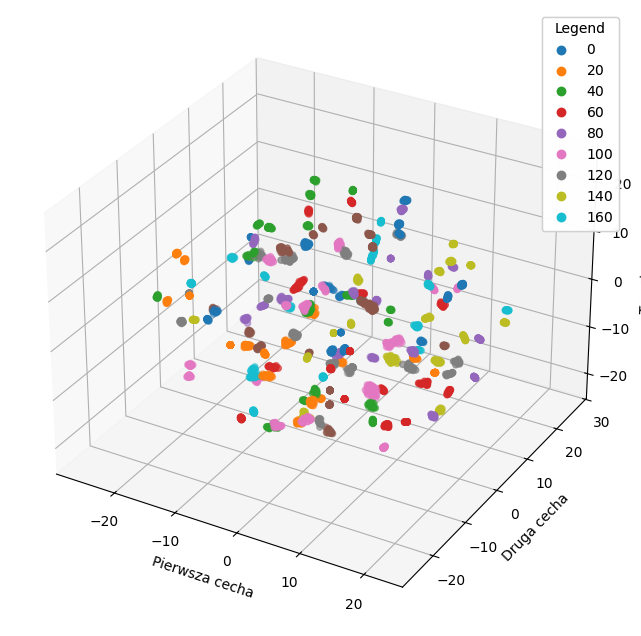

In [216]:
X_train_tsne_df = pd.DataFrame(X_train_tsne, columns=["Dim1", "Dim2", "Dim3"])
X_train_tsne_df["Name"] = y_train

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

palette = sns.color_palette("tab10", as_cmap=True)

scatter = ax.scatter(X_train_tsne_df["Dim1"], X_train_tsne_df["Dim2"], X_train_tsne_df["Dim3"],
                     c=pd.Categorical(X_train_tsne_df["Name"]).codes, cmap=palette)

ax.set_xlabel("Pierwsza cecha")
ax.set_ylabel("Druga cecha")
ax.set_zlabel("Trzecia cecha")

legend1 = ax.legend(*scatter.legend_elements(), title="Legend")
ax.add_artist(legend1)

# Pokaż wykres
plt.show()